## 1. Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")
print(f"📅 Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully!
📅 Processing Date: 2025-11-21 19:56:41


## 2. Configuration

In [24]:
# Directories
RAW_DATA_DIR = '../../data/raw'
PROCESSED_DATA_DIR = '../../data/processed'
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Train/Val/Test split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Ticker categories - EXPANDED DATASET (26 assets)
TICKERS = {
    'indices': ['GSPC', 'IXIC', 'DJI', 'FTSE', 'N225', 'HSI', 'GDAXI'],
    'stocks': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'XOM', 'JNJ', 'V', 'WMT', 'PG'],
    'crypto': ['BTC_USD', 'ETH_USD', 'BNB_USD', 'SOL_USD', 'ADA_USD'],
    'commodities': ['GC=F', 'VIX', 'CL=F']
}

print(f"📂 Raw data directory: {RAW_DATA_DIR}")
print(f"📂 Processed data directory: {PROCESSED_DATA_DIR}")
print(f"\n📊 Data Split:")
print(f"   - Training: {TRAIN_RATIO*100:.0f}%")
print(f"   - Validation: {VAL_RATIO*100:.0f}%")
print(f"   - Test: {TEST_RATIO*100:.0f}%")
print(f"\n📈 Total Assets: {sum(len(v) for v in TICKERS.values())}")
for category, tickers in TICKERS.items():
    print(f"   - {category.capitalize()}: {len(tickers)} assets")

📂 Raw data directory: ../../data/raw
📂 Processed data directory: ../../data/processed

📊 Data Split:
   - Training: 70%
   - Validation: 15%
   - Test: 15%

📈 Total Assets: 26
   - Indices: 7 assets
   - Stocks: 11 assets
   - Crypto: 5 assets
   - Commodities: 3 assets


## 3. Load and Fix Raw Data

The raw CSV files have MultiIndex columns that need to be flattened.

In [25]:
def load_and_clean_ticker(ticker_file):
    """
    Load a ticker CSV file and clean the column structure.
    
    Parameters:
    -----------
    ticker_file : str
        Filename of the ticker CSV
    
    Returns:
    --------
    pd.DataFrame
        Cleaned dataframe with proper column names
    """
    filepath = os.path.join(RAW_DATA_DIR, ticker_file)
    
    # Load data with MultiIndex header
    df = pd.read_csv(filepath, header=[0, 1], index_col=0, parse_dates=True)
    
    # Flatten MultiIndex columns - keep only the first level (column names)
    df.columns = [col[0] for col in df.columns]
    
    # Ensure standard column names and order
    expected_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df[expected_cols]
    
    # Convert to numeric (in case there are any string values)
    for col in expected_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by date
    df = df.sort_index()
    
    # Remove any duplicate dates
    df = df[~df.index.duplicated(keep='first')]
    
    # Drop any rows with all NaN values
    df = df.dropna(how='all')
    
    return df

print("✅ Data loading function defined")

✅ Data loading function defined


In [26]:
# Load all tickers
print("📥 Loading and cleaning data...\n")

cleaned_data = {}

for category, tickers in TICKERS.items():
    print(f"{'='*60}")
    print(f"📂 Category: {category.upper()}")
    print(f"{'='*60}")
    
    for ticker in tickers:
        try:
            filename = f"{ticker}.csv"
            df = load_and_clean_ticker(filename)
            cleaned_data[ticker] = df
            print(f"✅ {ticker:10s} - {len(df):,} rows | {str(df.index.min())[:10]} to {str(df.index.max())[:10]}")
        except Exception as e:
            print(f"❌ {ticker:10s} - Error: {str(e)}")

print(f"\n{'='*60}")
print(f"✅ Loaded {len(cleaned_data)} tickers successfully")
print(f"{'='*60}")

📥 Loading and cleaning data...

📂 Category: INDICES
✅ GSPC       - 2,515 rows | 2015-01-02 to 2024-12-30
✅ IXIC       - 2,515 rows | 2015-01-02 to 2024-12-30
✅ DJI        - 2,515 rows | 2015-01-02 to 2024-12-30
✅ FTSE       - 2,524 rows | 2015-01-02 to 2024-12-30
✅ N225       - 2,445 rows | 2015-01-05 to 2024-12-30
✅ HSI        - 2,459 rows | 2015-01-02 to 2024-12-30
✅ GDAXI      - 2,537 rows | 2015-01-02 to 2024-12-30
📂 Category: STOCKS
✅ AAPL       - 2,515 rows | 2015-01-02 to 2024-12-30
✅ MSFT       - 2,515 rows | 2015-01-02 to 2024-12-30
✅ GOOGL      - 2,515 rows | 2015-01-02 to 2024-12-30
✅ AMZN       - 2,515 rows | 2015-01-02 to 2024-12-30
✅ TSLA       - 2,515 rows | 2015-01-02 to 2024-12-30
✅ JPM        - 2,515 rows | 2015-01-02 to 2024-12-30
✅ XOM        - 2,515 rows | 2015-01-02 to 2024-12-30
✅ JNJ        - 2,515 rows | 2015-01-02 to 2024-12-30
✅ V          - 2,515 rows | 2015-01-02 to 2024-12-30
✅ WMT        - 2,515 rows | 2015-01-02 to 2024-12-30
✅ PG         - 2,515 rows | 

## 4. Verify Data Alignment

Check if all assets have aligned dates (important for correlation analysis and multi-asset modeling).

In [28]:
# Find common date range
all_dates = [df.index for df in cleaned_data.values()]
common_start = max([dates.min() for dates in all_dates])
common_end = min([dates.max() for dates in all_dates])

print(f"📅 Date Range Analysis:\n")
print(f"Common start date: {common_start.date()}")
print(f"Common end date: {common_end.date()}")
print(f"Common trading days: {len(pd.date_range(common_start, common_end, freq='D'))} calendar days\n")

# Show individual ranges
print("Individual ticker date ranges:")
for ticker, df in cleaned_data.items():
    print(f"{ticker:10s}: {df.index.min().date()} to {df.index.max().date()} ({len(df):,} rows)")

print(f"\n⚠️  Note: ETH_USD has shorter history (started Nov 2017) - this is normal")

📅 Date Range Analysis:

Common start date: 2020-04-10
Common end date: 2024-12-30
Common trading days: 1726 calendar days

Individual ticker date ranges:
GSPC      : 2015-01-02 to 2024-12-30 (2,515 rows)
IXIC      : 2015-01-02 to 2024-12-30 (2,515 rows)
DJI       : 2015-01-02 to 2024-12-30 (2,515 rows)
FTSE      : 2015-01-02 to 2024-12-30 (2,524 rows)
N225      : 2015-01-05 to 2024-12-30 (2,445 rows)
HSI       : 2015-01-02 to 2024-12-30 (2,459 rows)
GDAXI     : 2015-01-02 to 2024-12-30 (2,537 rows)
AAPL      : 2015-01-02 to 2024-12-30 (2,515 rows)
MSFT      : 2015-01-02 to 2024-12-30 (2,515 rows)
GOOGL     : 2015-01-02 to 2024-12-30 (2,515 rows)
AMZN      : 2015-01-02 to 2024-12-30 (2,515 rows)
TSLA      : 2015-01-02 to 2024-12-30 (2,515 rows)
JPM       : 2015-01-02 to 2024-12-30 (2,515 rows)
XOM       : 2015-01-02 to 2024-12-30 (2,515 rows)
JNJ       : 2015-01-02 to 2024-12-30 (2,515 rows)
V         : 2015-01-02 to 2024-12-30 (2,515 rows)
WMT       : 2015-01-02 to 2024-12-30 (2,515 ro

## 5. Calculate Returns

Calculate both simple and log returns for each asset.

In [27]:
def calculate_returns(df):
    """
    Calculate simple and log returns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with OHLCV data
    
    Returns:
    --------
    pd.DataFrame
        Original data with added return columns
    """
    df = df.copy()
    
    # Simple returns: (P_t - P_{t-1}) / P_{t-1}
    df['Returns'] = df['Close'].pct_change()
    
    # Log returns: ln(P_t / P_{t-1})
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Volume change
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # Price range (High - Low)
    df['Price_Range'] = df['High'] - df['Low']
    
    # Intraday return
    df['Intraday_Return'] = (df['Close'] - df['Open']) / df['Open']
    
    return df

print("✅ Return calculation function defined")

✅ Return calculation function defined


In [29]:
# Calculate returns for all tickers
print("📊 Calculating returns...\n")

processed_data = {}

for ticker, df in cleaned_data.items():
    processed_data[ticker] = calculate_returns(df)
    print(f"✅ {ticker:10s} - Added 5 new features (Returns, Log_Returns, etc.)")

print(f"\n✅ Returns calculated for all {len(processed_data)} tickers")

📊 Calculating returns...

✅ GSPC       - Added 5 new features (Returns, Log_Returns, etc.)
✅ IXIC       - Added 5 new features (Returns, Log_Returns, etc.)
✅ DJI        - Added 5 new features (Returns, Log_Returns, etc.)
✅ FTSE       - Added 5 new features (Returns, Log_Returns, etc.)
✅ N225       - Added 5 new features (Returns, Log_Returns, etc.)
✅ HSI        - Added 5 new features (Returns, Log_Returns, etc.)
✅ GDAXI      - Added 5 new features (Returns, Log_Returns, etc.)
✅ AAPL       - Added 5 new features (Returns, Log_Returns, etc.)
✅ MSFT       - Added 5 new features (Returns, Log_Returns, etc.)
✅ GOOGL      - Added 5 new features (Returns, Log_Returns, etc.)
✅ AMZN       - Added 5 new features (Returns, Log_Returns, etc.)
✅ TSLA       - Added 5 new features (Returns, Log_Returns, etc.)
✅ JPM        - Added 5 new features (Returns, Log_Returns, etc.)
✅ XOM        - Added 5 new features (Returns, Log_Returns, etc.)
✅ JNJ        - Added 5 new features (Returns, Log_Returns, etc.)

In [30]:
# Display sample processed data
print("📈 Sample Processed Data (S&P 500):\n")
if 'GSPC' in processed_data:
    sample_df = processed_data['GSPC'].tail(10)
    print(sample_df[['Close', 'Returns', 'Log_Returns', 'Volume']].to_string())
    
    print("\n📊 Summary Statistics:")
    print(processed_data['GSPC'][['Returns', 'Log_Returns']].describe())

📈 Sample Processed Data (S&P 500):

                  Close   Returns  Log_Returns      Volume
Date                                                      
2024-12-16  6074.080078  0.003799     0.003792  4391100000
2024-12-17  6050.609863 -0.003864    -0.003871  4544500000
2024-12-18  5872.160156 -0.029493    -0.029937  5246960000
2024-12-19  5867.080078 -0.000865    -0.000865  4896880000
2024-12-20  5930.850098  0.010869     0.010810  8223220000
2024-12-23  5974.069824  0.007287     0.007261  3593280000
2024-12-24  6040.040039  0.011043     0.010982  1757720000
2024-12-26  6037.589844 -0.000406    -0.000406  2904530000
2024-12-27  5970.839844 -0.011056    -0.011117  3159610000
2024-12-30  5906.939941 -0.010702    -0.010760  3433250000

📊 Summary Statistics:
           Returns  Log_Returns
count  2514.000000  2514.000000
mean      0.000483     0.000419
std       0.011232     0.011272
min      -0.119841    -0.127652
25%      -0.003773    -0.003780
50%       0.000639     0.000639
75%      

## 6. Handle Missing Values

Check for and handle any NaN values (typically from return calculations on first row).

In [31]:
# Check missing values
print("🔍 Missing Values Analysis:\n")

for ticker, df in processed_data.items():
    missing = df.isnull().sum()
    total_missing = missing.sum()
    
    if total_missing > 0:
        print(f"\n{ticker}:")
        print(missing[missing > 0])
    else:
        print(f"✅ {ticker:10s}: No missing values")

print("\n⚠️  Note: First row NaN values are expected from return calculations")

🔍 Missing Values Analysis:


GSPC:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

IXIC:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

DJI:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

FTSE:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

N225:
Returns          1
Log_Returns      1
Volume_Change    2
dtype: int64

HSI:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

GDAXI:
Returns          1
Log_Returns      1
Volume_Change    3
dtype: int64

AAPL:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

MSFT:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

GOOGL:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

AMZN:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

TSLA:
Returns          1
Log_Returns      1
Volume_Change    1
dtype: int64

JPM:
Returns          1
Log_Returns      1
Volu

In [32]:
# Remove first row (contains NaN from return calculations)
print("🧹 Cleaning data (removing first row with NaN returns)...\n")

for ticker in processed_data.keys():
    original_len = len(processed_data[ticker])
    processed_data[ticker] = processed_data[ticker].dropna()
    new_len = len(processed_data[ticker])
    print(f"{ticker:10s}: {original_len} → {new_len} rows ({original_len - new_len} removed)")

print("\n✅ Data cleaning complete")

🧹 Cleaning data (removing first row with NaN returns)...

GSPC      : 2515 → 2514 rows (1 removed)
IXIC      : 2515 → 2514 rows (1 removed)
DJI       : 2515 → 2514 rows (1 removed)
FTSE      : 2524 → 2523 rows (1 removed)
N225      : 2445 → 2443 rows (2 removed)
HSI       : 2459 → 2458 rows (1 removed)
GDAXI     : 2537 → 2534 rows (3 removed)
AAPL      : 2515 → 2514 rows (1 removed)
MSFT      : 2515 → 2514 rows (1 removed)
GOOGL     : 2515 → 2514 rows (1 removed)
AMZN      : 2515 → 2514 rows (1 removed)
TSLA      : 2515 → 2514 rows (1 removed)
JPM       : 2515 → 2514 rows (1 removed)
XOM       : 2515 → 2514 rows (1 removed)
JNJ       : 2515 → 2514 rows (1 removed)
V         : 2515 → 2514 rows (1 removed)
WMT       : 2515 → 2514 rows (1 removed)
PG        : 2515 → 2514 rows (1 removed)
BTC_USD   : 3652 → 3651 rows (1 removed)
ETH_USD   : 2609 → 2608 rows (1 removed)
BNB_USD   : 2609 → 2608 rows (1 removed)
SOL_USD   : 1726 → 1725 rows (1 removed)
ADA_USD   : 2609 → 2608 rows (1 removed)

## 7. Create Train/Validation/Test Splits

**Important:** For time-series, we use temporal splits (NOT random splits).

In [33]:
def create_temporal_split(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    """
    Create temporal train/validation/test splits.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Time-series dataframe
    train_ratio : float
        Proportion of data for training
    val_ratio : float
        Proportion of data for validation
    test_ratio : float
        Proportion of data for testing
    
    Returns:
    --------
    dict
        Dictionary with 'train', 'val', 'test' splits
    """
    n = len(df)
    
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    splits = {
        'train': df.iloc[:train_end],
        'val': df.iloc[train_end:val_end],
        'test': df.iloc[val_end:]
    }
    
    return splits

print("✅ Temporal split function defined")

✅ Temporal split function defined


In [34]:
# Create splits for all tickers
print("✂️  Creating temporal splits...\n")

splits_data = {}

for ticker, df in processed_data.items():
    splits = create_temporal_split(df, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
    splits_data[ticker] = splits
    
    print(f"{ticker}:")
    print(f"  Train: {len(splits['train']):4d} rows | {splits['train'].index.min().date()} to {splits['train'].index.max().date()}")
    print(f"  Val:   {len(splits['val']):4d} rows | {splits['val'].index.min().date()} to {splits['val'].index.max().date()}")
    print(f"  Test:  {len(splits['test']):4d} rows | {splits['test'].index.min().date()} to {splits['test'].index.max().date()}")
    print()

print("✅ Temporal splits created for all tickers")

✂️  Creating temporal splits...

GSPC:
  Train: 1759 rows | 2015-01-05 to 2021-12-28
  Val:    377 rows | 2021-12-29 to 2023-06-29
  Test:   378 rows | 2023-06-30 to 2024-12-30

IXIC:
  Train: 1759 rows | 2015-01-05 to 2021-12-28
  Val:    377 rows | 2021-12-29 to 2023-06-29
  Test:   378 rows | 2023-06-30 to 2024-12-30

DJI:
  Train: 1759 rows | 2015-01-05 to 2021-12-28
  Val:    377 rows | 2021-12-29 to 2023-06-29
  Test:   378 rows | 2023-06-30 to 2024-12-30

FTSE:
  Train: 1766 rows | 2015-01-05 to 2021-12-24
  Val:    378 rows | 2021-12-29 to 2023-07-03
  Test:   379 rows | 2023-07-04 to 2024-12-30

N225:
  Train: 1710 rows | 2015-01-06 to 2022-01-05
  Val:    366 rows | 2022-01-06 to 2023-07-04
  Test:   367 rows | 2023-07-05 to 2024-12-30

HSI:
  Train: 1720 rows | 2015-01-05 to 2021-12-24
  Val:    369 rows | 2021-12-28 to 2023-06-29
  Test:   369 rows | 2023-06-30 to 2024-12-30

GDAXI:
  Train: 1773 rows | 2015-01-05 to 2022-01-05
  Val:    380 rows | 2022-01-06 to 2023-06-29


## 8. Visualize Data Splits

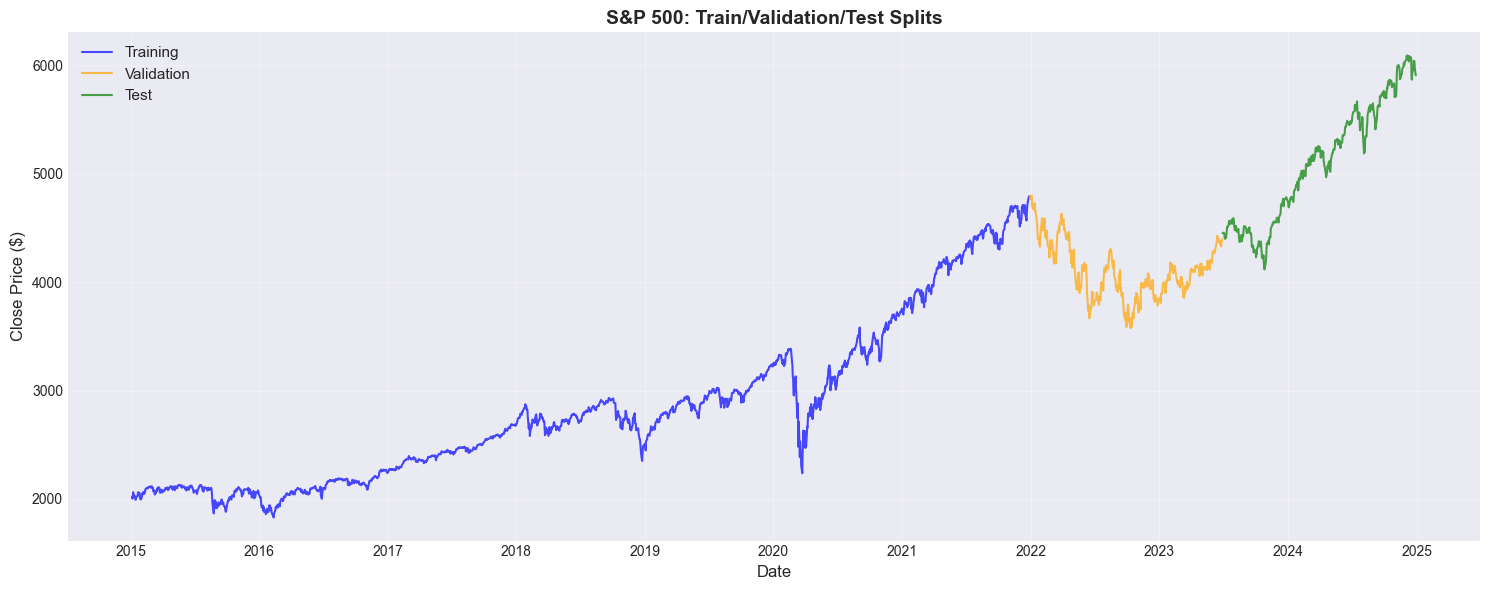

✅ Split visualization saved to outputs/figures/02_data_splits.png


In [35]:
# Visualize splits for S&P 500
if 'GSPC' in splits_data:
    fig, ax = plt.subplots(figsize=(15, 6))
    
    splits = splits_data['GSPC']
    
    # Plot each split with different colors
    ax.plot(splits['train'].index, splits['train']['Close'], 
            label='Training', color='blue', alpha=0.7, linewidth=1.5)
    ax.plot(splits['val'].index, splits['val']['Close'], 
            label='Validation', color='orange', alpha=0.7, linewidth=1.5)
    ax.plot(splits['test'].index, splits['test']['Close'], 
            label='Test', color='green', alpha=0.7, linewidth=1.5)
    
    ax.set_title('S&P 500: Train/Validation/Test Splits', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Close Price ($)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../outputs/figures/02_data_splits.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Split visualization saved to outputs/figures/02_data_splits.png")

## 9. Return Distribution Analysis

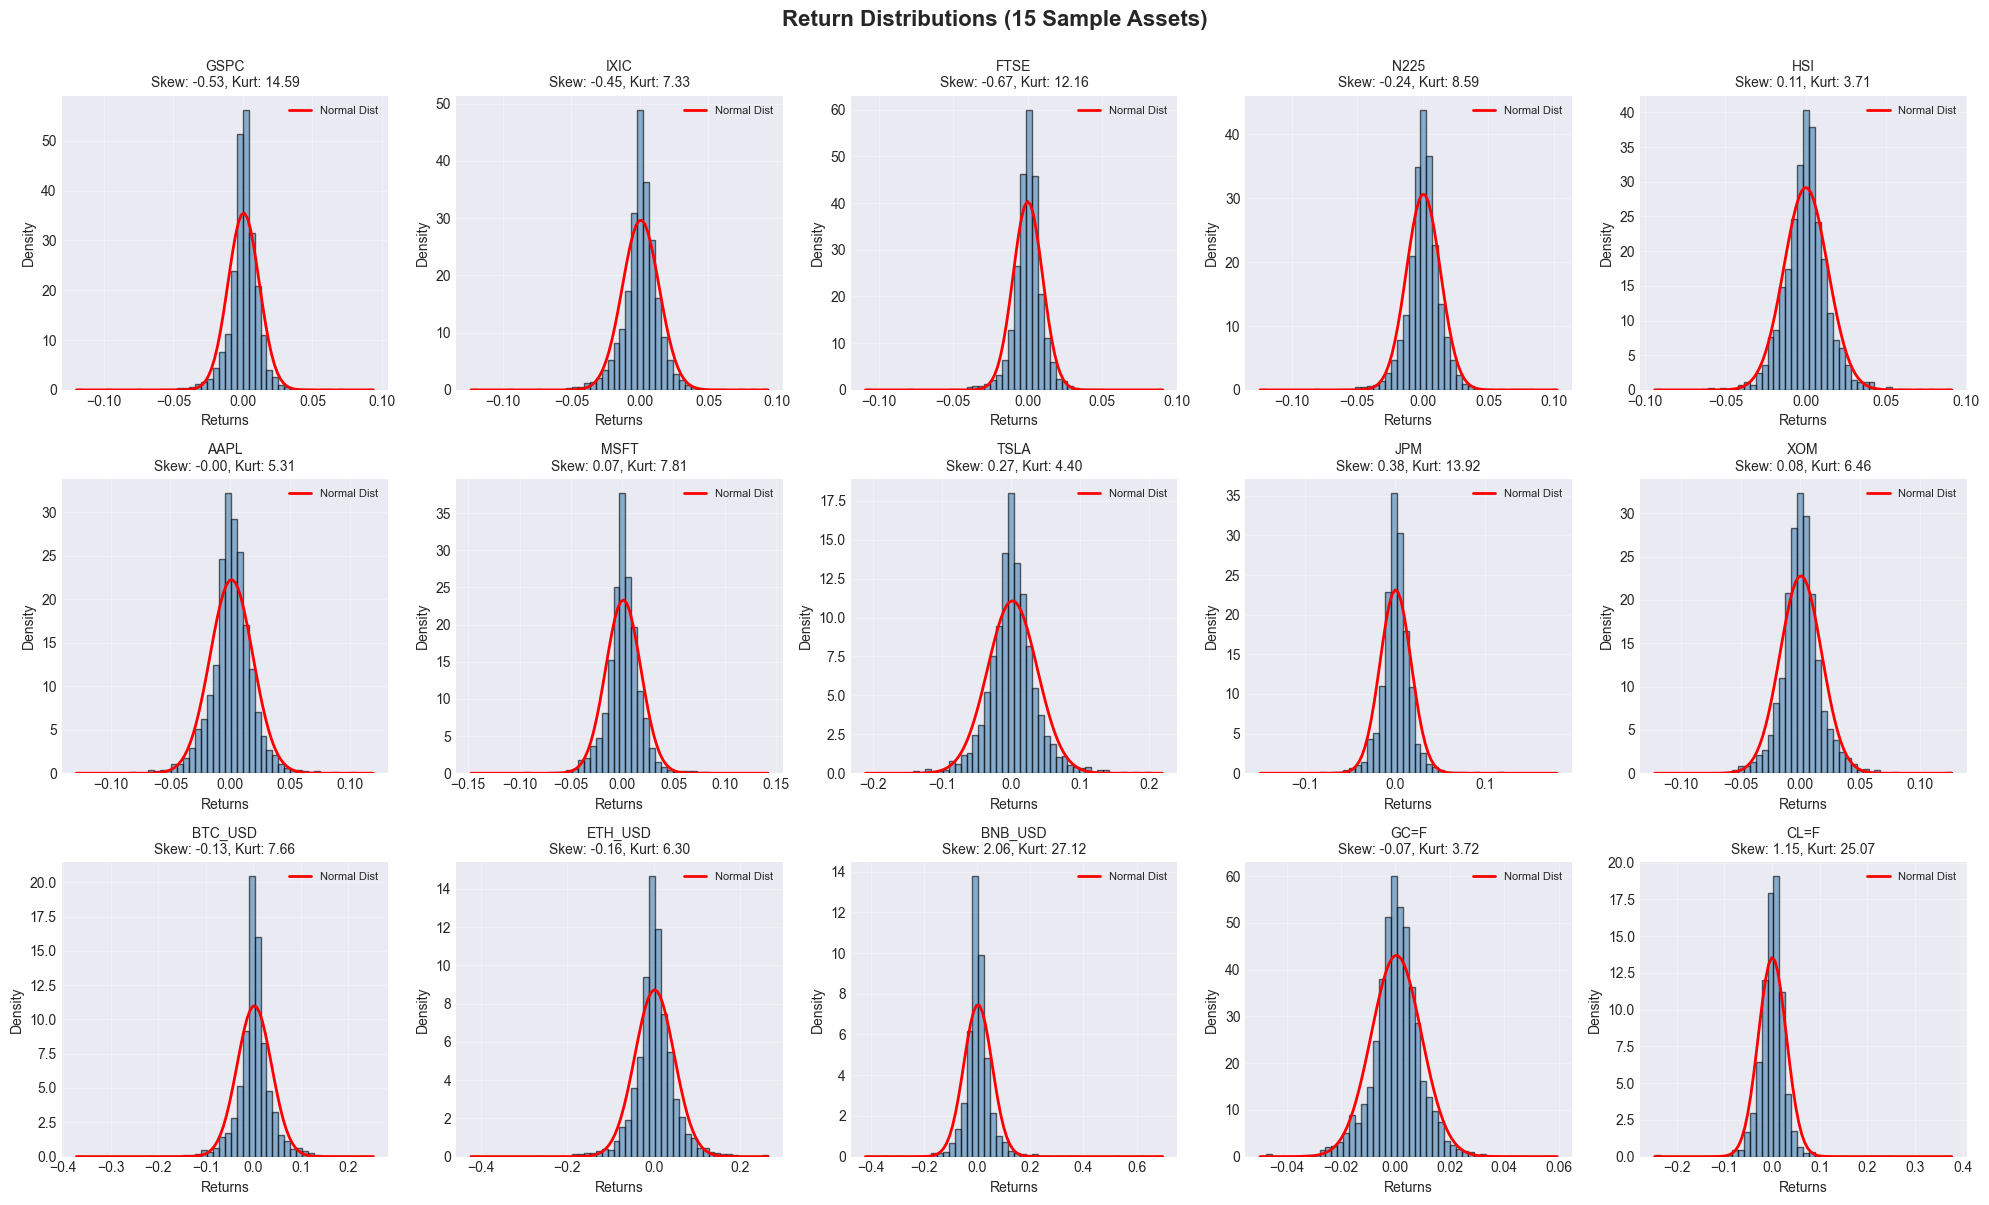

✅ Return distribution visualization saved

📊 Note: Financial returns typically show:
   - Fat tails (high kurtosis > 3)
   - Slight negative skewness
   - Deviation from normal distribution


In [36]:
# Plot return distributions for a sample of assets
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

# Select 15 representative assets to visualize
sample_tickers = ['GSPC', 'IXIC', 'FTSE', 'N225', 'HSI',  # Indices
                  'AAPL', 'MSFT', 'TSLA', 'JPM', 'XOM',   # Stocks
                  'BTC_USD', 'ETH_USD', 'BNB_USD',         # Crypto
                  'GC=F', 'CL=F']                          # Commodities

for idx, ticker in enumerate(sample_tickers):
    if ticker in processed_data:
        ax = axes[idx]
        returns = processed_data[ticker]['Returns'].dropna()
        
        # Histogram with KDE
        ax.hist(returns, bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)
        
        # Overlay normal distribution
        from scipy import stats
        mu, std = returns.mean(), returns.std()
        x = np.linspace(returns.min(), returns.max(), 100)
        ax.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Normal Dist')
        
        # Statistics
        skew = returns.skew()
        kurt = returns.kurtosis()
        
        ax.set_title(f'{ticker}\nSkew: {skew:.2f}, Kurt: {kurt:.2f}', fontsize=10)
        ax.set_xlabel('Returns')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle('Return Distributions (15 Sample Assets)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../../outputs/figures/02_return_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Return distribution visualization saved")
print("\n📊 Note: Financial returns typically show:")
print("   - Fat tails (high kurtosis > 3)")
print("   - Slight negative skewness")
print("   - Deviation from normal distribution")

## 10. Save Processed Data

In [37]:
# Save full processed data
print("💾 Saving processed data...\n")

for ticker, df in processed_data.items():
    # Save full processed data
    filepath = os.path.join(PROCESSED_DATA_DIR, f"{ticker}_processed.csv")
    df.to_csv(filepath)
    print(f"✅ {ticker:10s} → {filepath}")

print(f"\n✅ Processed data saved to {PROCESSED_DATA_DIR}")

💾 Saving processed data...

✅ GSPC       → ../../data/processed\GSPC_processed.csv
✅ IXIC       → ../../data/processed\IXIC_processed.csv
✅ DJI        → ../../data/processed\DJI_processed.csv
✅ FTSE       → ../../data/processed\FTSE_processed.csv
✅ N225       → ../../data/processed\N225_processed.csv
✅ HSI        → ../../data/processed\HSI_processed.csv
✅ GDAXI      → ../../data/processed\GDAXI_processed.csv
✅ AAPL       → ../../data/processed\AAPL_processed.csv
✅ MSFT       → ../../data/processed\MSFT_processed.csv
✅ GOOGL      → ../../data/processed\GOOGL_processed.csv
✅ AMZN       → ../../data/processed\AMZN_processed.csv
✅ TSLA       → ../../data/processed\TSLA_processed.csv
✅ JPM        → ../../data/processed\JPM_processed.csv
✅ XOM        → ../../data/processed\XOM_processed.csv
✅ JNJ        → ../../data/processed\JNJ_processed.csv
✅ AAPL       → ../../data/processed\AAPL_processed.csv
✅ MSFT       → ../../data/processed\MSFT_processed.csv
✅ GOOGL      → ../../data/processed\GOOG

In [38]:
# Save train/val/test splits
print("\n💾 Saving train/val/test splits...\n")

for split_name in ['train', 'val', 'test']:
    split_dir = os.path.join(PROCESSED_DATA_DIR, split_name)
    os.makedirs(split_dir, exist_ok=True)
    
    print(f"📂 {split_name.upper()}:")
    for ticker, splits in splits_data.items():
        filepath = os.path.join(split_dir, f"{ticker}_{split_name}.csv")
        splits[split_name].to_csv(filepath)
        print(f"  ✅ {ticker}_{split_name}.csv")

print(f"\n✅ All splits saved successfully")


💾 Saving train/val/test splits...

📂 TRAIN:
  ✅ GSPC_train.csv
  ✅ IXIC_train.csv
  ✅ DJI_train.csv
  ✅ FTSE_train.csv
  ✅ N225_train.csv
  ✅ HSI_train.csv
  ✅ GDAXI_train.csv
  ✅ AAPL_train.csv
  ✅ MSFT_train.csv
  ✅ GOOGL_train.csv
  ✅ AMZN_train.csv
  ✅ TSLA_train.csv
  ✅ JPM_train.csv
  ✅ XOM_train.csv
  ✅ JNJ_train.csv
  ✅ V_train.csv
  ✅ WMT_train.csv
  ✅ PG_train.csv
  ✅ BTC_USD_train.csv
  ✅ ETH_USD_train.csv
  ✅ BNB_USD_train.csv
  ✅ SOL_USD_train.csv
  ✅ TSLA_train.csv
  ✅ JPM_train.csv
  ✅ XOM_train.csv
  ✅ JNJ_train.csv
  ✅ V_train.csv
  ✅ WMT_train.csv
  ✅ PG_train.csv
  ✅ BTC_USD_train.csv
  ✅ ETH_USD_train.csv
  ✅ BNB_USD_train.csv
  ✅ SOL_USD_train.csv
  ✅ ADA_USD_train.csv
  ✅ GC=F_train.csv
  ✅ VIX_train.csv
  ✅ CL=F_train.csv
📂 VAL:
  ✅ GSPC_val.csv
  ✅ IXIC_val.csv
  ✅ DJI_val.csv
  ✅ FTSE_val.csv
  ✅ N225_val.csv
  ✅ HSI_val.csv
  ✅ GDAXI_val.csv
  ✅ AAPL_val.csv
  ✅ MSFT_val.csv
  ✅ GOOGL_val.csv
  ✅ AMZN_val.csv
  ✅ TSLA_val.csv
  ✅ JPM_val.csv
  ✅ XOM_val.csv
 

## 11. Create Summary Statistics

In [40]:
# Generate comprehensive summary
summary_stats = []

for ticker, df in processed_data.items():
    # Skip if dataframe is empty (like VIX which had issues)
    if len(df) == 0:
        print(f"⚠️  Skipping {ticker}: Empty dataframe")
        continue
    
    returns = df['Returns'].dropna()
    
    stats = {
        'Ticker': ticker,
        'Total_Rows': len(df),
        'Start_Date': df.index.min().strftime('%Y-%m-%d'),
        'End_Date': df.index.max().strftime('%Y-%m-%d'),
        'Mean_Return': returns.mean(),
        'Std_Return': returns.std(),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        'Min_Return': returns.min(),
        'Max_Return': returns.max(),
        'Sharpe_Ratio': (returns.mean() / returns.std()) * np.sqrt(252)  # Annualized
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)

print("\n📊 Summary Statistics:")
print(summary_df.to_string(index=False))

# Save summary
summary_path = os.path.join(PROCESSED_DATA_DIR, '_processing_summary.csv')
summary_df.to_csv(summary_path, index=False)
print(f"\n💾 Summary saved to {summary_path}")
print(f"\n✅ Successfully processed {len(summary_df)} assets")

⚠️  Skipping VIX: Empty dataframe

📊 Summary Statistics:
 Ticker  Total_Rows Start_Date   End_Date  Mean_Return  Std_Return  Skewness  Kurtosis  Min_Return  Max_Return  Sharpe_Ratio
   GSPC        2514 2015-01-05 2024-12-30     0.000483    0.011232 -0.528408 14.591989   -0.119841    0.093828      0.682346
   IXIC        2514 2015-01-05 2024-12-30     0.000654    0.013444 -0.451651  7.330793   -0.123213    0.093460      0.772633
    DJI        2514 2015-01-05 2024-12-30     0.000408    0.011049 -0.556712 21.138602   -0.129265    0.113650      0.585509
   FTSE        2523 2015-01-05 2024-12-30     0.000134    0.009889 -0.670835 12.161517   -0.108738    0.090530      0.215862
   N225        2443 2015-01-06 2024-12-30     0.000424    0.012996 -0.238331  8.594836   -0.123958    0.102263      0.517536
    HSI        2458 2015-01-05 2024-12-30     0.000025    0.013673  0.108409  3.711128   -0.094070    0.090818      0.028815
  GDAXI        2534 2015-01-05 2024-12-30     0.000346    0.012094 -

## 12. Next Steps

✅ **Data preprocessing complete!**

**Files Created:**
- `data/processed/{ticker}_processed.csv` - Full processed data with returns
- `data/processed/train/{ticker}_train.csv` - Training splits
- `data/processed/val/{ticker}_val.csv` - Validation splits
- `data/processed/test/{ticker}_test.csv` - Test splits
- `data/processed/_processing_summary.csv` - Statistical summary

**Next Notebooks:**
1. `03_eda_and_stl.ipynb` - Exploratory Data Analysis and STL Decomposition
2. `04_feature_engineering.ipynb` - Advanced feature creation (volatility, technical indicators)

**Key Findings:**
- All data successfully cleaned and processed
- Returns calculated (simple and log)
- Temporal splits created (70/15/15)
- Ready for modeling and analysis